### library

In [1]:
import psutil
import os
def get_available_memory_gb():
    """Returns the amount of available physical memory in gigabytes."""
    # Get virtual memory statistics
    mem = psutil.virtual_memory()
    # Convert available memory from bytes to gigabytes
    available_gb = mem.available / (1024**3)
    return available_gb

print(f"Available RAM: {get_available_memory_gb():.2f} GB")
print(f'number of CPU cores:{os.cpu_count()}')

Available RAM: 3.71 GB
number of CPU cores:20


In [2]:
import pandas as pd
import numpy as np
import os

### plots
import matplotlib.pyplot as plt
import seaborn as sns

### better formatting
from IPython.display import display
import textwrap

### feature encoding
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer,MinMaxScaler,StandardScaler, TargetEncoder
from itertools import combinations


## model
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

### evaluation
from sklearn.metrics import roc_auc_score, make_scorer


# ### system launch, not used
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import FunctionTransformer

###  check sklearn version
# import sklearn
# print(sklearn.__version__)


### dataset reading

In [3]:
train = pd.read_csv(r'd:/python/github/Data-Science/binary_classi_bank_data/data/train.csv')
test = pd.read_csv(r'd:/python/github/Data-Science/binary_classi_bank_data/data/test.csv')

orig = pd.read_csv(r'd:/python/github/Data-Science/binary_classi_bank_data/data/bank-full.csv',sep=';')

# train_data = pd.concat([train_data_new, old_data], ignore_index=True)
print(f'train shape {train.shape}, test shape {test.shape}, old data shape {orig.shape}')

train shape (750000, 18), test shape (250000, 17), old data shape (45211, 17)


In [4]:
### set aside 250k for evaluation (remaining), resemble test set
train,remaining = train_test_split(train, test_size=25/75, random_state=2)
print(f'train shape {train.shape}, remaining shape {remaining.shape}')

train shape (500000, 18), remaining shape (250000, 18)


In [5]:
### format old data the same target variable as training data
orig['y'] = orig['y'].apply(lambda x: 1 if x == 'yes' else 0)

## drop id column in train
train.drop(['id'], axis=1, inplace=True)
print(f'train shape:{train.shape}')

### concat old data with train
train = pd.concat([orig,train, orig, orig, orig, orig], ignore_index=True)

### preview train dataset
print(f'combined train shape{train.shape}')
display(train.head(5))

### submission data frame
predict_df = test[['id']].copy()
test.drop('id', axis=1, inplace=True)

train shape:(500000, 17)
combined train shape(726055, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


### column preprocess

#### data type process

In [6]:
#### column data type formating: yes/no -> 1/0

def column_type_preprocess(df):
    ### to prevent many times running error
    if df['default'].dtypes == 'float64':
        return df

    ### boolean
    boolean_col_map = {'no':0, 'yes':1}
    df['default'] = df['default'].map(boolean_col_map)
    df['housing'] = df['housing'].map(boolean_col_map)
    df['loan'] = df['loan'].map(boolean_col_map)

    ### outcome
    df['poutcome'] = df['poutcome'].map({
        'unknown': -1,
        'other': -1,
        'failure': 0,
        'success': 1
    })

### process for train/test/remaining
column_type_preprocess(train)
column_type_preprocess(test)
column_type_preprocess(remaining)

In [7]:
#### feature columns
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train.select_dtypes(include=['float64','int64']).columns.tolist()
numeric_cols.remove('y')

print(f'numeric columns {len(numeric_cols)}\n{numeric_cols}')
print(f'\nstring columns {len(categorical_cols)}\n{categorical_cols}')

numeric columns 11
['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']

string columns 5
['job', 'marital', 'education', 'contact', 'month']


In [ ]:
# ### check if test and train columns have same value for original categorical values
# for col in categorical_cols:
#     print(f'{col}:\t test has {len(set(test[col].unique())-set(train[col].unique()))} new values compared with train')

job:	 test has 0 new values compared with train
marital:	 test has 0 new values compared with train
education:	 test has 0 new values compared with train
contact:	 test has 0 new values compared with train
month:	 test has 0 new values compared with train


#### replicate numeric columns

In [10]:
%%time
### duplicate numerical cols to string cols
def duplicate_num_cols(df, num_cols, cat_cols):
    ### treat -1 as a very large days
    df.loc[df['pdays']==-1,'pdays'] = 10000
    
    for col in num_cols:
        ### numeric cols to string
        new_col_name1 = col + '_cat'

        df[new_col_name1] = df[col].astype(str)

        ## new columns added to categorical value list
        if new_col_name1 not in cat_cols:
            cat_cols.append(new_col_name1)


### duplicate num columns for train/test/remaining
duplicate_num_cols(train,numeric_cols,categorical_cols)
print(f'total train columns:{train.columns}\n\n new categorical cols (length {len(categorical_cols)}):{categorical_cols}\n')

### duplicate num columns for test
duplicate_num_cols(test,numeric_cols,categorical_cols)

### duplicate num columns for remaining
duplicate_num_cols(remaining,numeric_cols,categorical_cols)

total train columns:Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'age_cat', 'default_cat', 'balance_cat',
       'housing_cat', 'loan_cat', 'day_cat', 'duration_cat', 'campaign_cat',
       'pdays_cat', 'previous_cat', 'poutcome_cat'],
      dtype='object')

 new categorical cols (length 16):['job', 'marital', 'education', 'contact', 'month', 'age_cat', 'default_cat', 'balance_cat', 'housing_cat', 'loan_cat', 'day_cat', 'duration_cat', 'campaign_cat', 'pdays_cat', 'previous_cat', 'poutcome_cat']

CPU times: total: 1.62 s
Wall time: 1.63 s


#### replace test new values with nearest train data

In [11]:
### test set:replace new values with nearest train data

for col in set(categorical_cols):
    ### if there is new values in test set
    if len(set(test[col].unique())-set(train[col].unique())) > 0:
        #### get all values in test set
        test_values = sorted(list(set(test[col].unique().astype(float))))
        #### get all values in train set
        train_values = sorted(list(set(train[col].unique().astype(float))))
        
        print(f'{col} has {len(set(test_values)-set(train_values))} new values')
        ### loop every new values in test set
        for value_t in set(test_values)-set(train_values):
            ### get nearst corresponding index in train value set
            min_index = abs(train_values - value_t).argmin()
            ### get target value from train col_cat column
            target_Value = train[train[col].astype(float)==train_values[min_index]][col].tolist()[0]
            ### print new value in test, its train value index, train value, and target value from train set
            # print(str(value_t), min_index, str(train_values[min_index]), target_Value)
            ### set back to test column value
            test.loc[test[col].astype(float)==value_t, col] = target_Value

duration_cat has 45 new values
pdays_cat has 18 new values
balance_cat has 246 new values
previous_cat has 3 new values


In [12]:
print('total categorical columns:', len(categorical_cols))
### ensure test and train columns have same value
for col in categorical_cols:
    print(f'{col}:\t test has {len(set(test[col].unique())-set(train[col].unique()))} new values compared with train')

total categorical columns: 16
job:	 test has 0 new values compared with train
marital:	 test has 0 new values compared with train
education:	 test has 0 new values compared with train
contact:	 test has 0 new values compared with train
month:	 test has 0 new values compared with train
age_cat:	 test has 0 new values compared with train
default_cat:	 test has 0 new values compared with train
balance_cat:	 test has 0 new values compared with train
housing_cat:	 test has 0 new values compared with train
loan_cat:	 test has 0 new values compared with train
day_cat:	 test has 0 new values compared with train
duration_cat:	 test has 0 new values compared with train
campaign_cat:	 test has 0 new values compared with train
pdays_cat:	 test has 0 new values compared with train
previous_cat:	 test has 0 new values compared with train
poutcome_cat:	 test has 0 new values compared with train


#### replace remaining set new values with nearest train data

In [13]:
### remaining set: replace new values with nearest train data, same process as test

for col in set(categorical_cols):
    ### if there is new values in remaining set
    if len(set(remaining[col].unique())-set(train[col].unique())) > 0:
        #### get all values in remaining set
        remain_values = sorted(list(set(remaining[col].unique().astype(float))))
        #### get all values in train set
        train_values = sorted(list(set(train[col].unique().astype(float))))
        
        print(f'{col} has {len(set(remain_values)-set(train_values))} new values')
        ### loop every new values in remaining set
        for value_t in set(remain_values)-set(train_values):
            ### get nearst corresponding index in train value set
            min_index = abs(train_values - value_t).argmin()
            ### get target value from train col_cat column
            target_Value = train[train[col].astype(float)==train_values[min_index]][col].tolist()[0]
            ### print new value in remaining, its train value index, train value, and target value from train set
            # print(str(value_t), min_index, str(train_values[min_index]), target_Value)
            ### set back to remaining column value
            remaining.loc[remaining[col].astype(float)==value_t, col] = target_Value

duration_cat has 36 new values
pdays_cat has 19 new values
balance_cat has 271 new values
previous_cat has 1 new values


In [14]:
print('total categorical columns:', len(categorical_cols))
### ensure remaining and train columns have same value
for col in categorical_cols:
    print(f'{col}:\t remaining has {len(set(remaining[col].unique())-set(train[col].unique()))} new values compared with train')

total categorical columns: 16
job:	 remaining has 0 new values compared with train
marital:	 remaining has 0 new values compared with train
education:	 remaining has 0 new values compared with train
contact:	 remaining has 0 new values compared with train
month:	 remaining has 0 new values compared with train
age_cat:	 remaining has 0 new values compared with train
default_cat:	 remaining has 0 new values compared with train
balance_cat:	 remaining has 0 new values compared with train
housing_cat:	 remaining has 0 new values compared with train
loan_cat:	 remaining has 0 new values compared with train
day_cat:	 remaining has 0 new values compared with train
duration_cat:	 remaining has 0 new values compared with train
campaign_cat:	 remaining has 0 new values compared with train
pdays_cat:	 remaining has 0 new values compared with train
previous_cat:	 remaining has 0 new values compared with train
poutcome_cat:	 remaining has 0 new values compared with train


#### pair-wise column generation

In [ ]:
#### ensure no duplication
categorical_cols = list(set(categorical_cols))

In [ ]:
%%time
### for all categorical values, combine every two of them to form a new column
def pair_columns(df, cat_cols):
    new_columns = []
    ### to prevent many times of insert, use a dictionary instead
    temp_df_dict = {}
    
    for (col_1, col_2) in list(combinations(cat_cols, 2)):
        ## new cat cols pair with old categorical 
        col_1, col_2 = sorted([col_1,col_2])
        
        new_col_name2 = col_1+'-'+col_2
        # print(new_col_name2)
        if not (new_col_name2 in new_columns):
            new_columns.append(new_col_name2)

            ## new columns generated and temporarily contained in a dictionary
            temp_df_dict[new_col_name2] = (df[col_1]+'-'+df[col_2])


    print('new columns generated: ',len(temp_df_dict))

    ### final one time merge to reduce operation
    df = df.merge(pd.DataFrame(temp_df_dict, index=df.index),
                 how='left', left_index=True, right_index=True)
    
    return df,new_columns

### generate pair-wise feature for train
train,new_cols_generated = pair_columns(train,categorical_cols)
print(f'train column length (total column length) {len(train.columns)}')

### process test
test,_ = pair_columns(test,categorical_cols)

### process remaining
remaining,_ = pair_columns(remaining,categorical_cols)

# train[categorical_cols] = train[categorical_cols].astype('category')
# test[categorical_cols] = test[categorical_cols].astype('category')


new columns generated:  120 120
train column length (total column length) 148
new columns generated:  120 120
new columns generated:  120 120
CPU times: total: 23.8 s
Wall time: 26.1 s


In [ ]:
new_categorical_cols = categorical_cols + list(set(new_cols_generated))
print(f'all category columns ({len(new_categorical_cols)}):\n')

all category columns (16):



#### target encoding for all category columns

In [17]:
%%time

# #### target encoding for all new categorical values
# ### main idea: compute y mean and frequency based on each cat col
# using maps to store new columns for mean and count, and final merge, to reduce time
# caution: not save mean and count values

if new_categorical_cols[0] not in train.columns:
    print('already processed, plese skip this cell')
else:
    train_new_cols = {}  ### shape: (len(train.index), len(new_categorical_cols)*2)
    test_new_cols = {}
    remain_new_cols = {}

    i = 0
    for col in new_categorical_cols:
    
        temp_df = train[[col,'y']].groupby([col])['y'].agg(['mean','count'])
        # print('processing col:', col)
        mean_map = temp_df['mean'].to_dict()
        count_map = temp_df['count'].to_dict()
    
        train_new_cols[col+'_mean'] = train[col].map(mean_map)
        train_new_cols[col+'_count'] = train[col].map(count_map)
    
        test_new_cols[col+'_mean'] = test[col].map(mean_map)
        test_new_cols[col+'_count'] = test[col].map(count_map)

        remain_new_cols[col+'_mean'] = remaining[col].map(mean_map)
        remain_new_cols[col+'_count'] = remaining[col].map(count_map)

        i +=  1
        if i%20==0:
            print('processed cols:', i)

    print('start to merging train')
    train=pd.concat([train, pd.DataFrame(train_new_cols,index=train.index)], 
              axis=1)

    print('start to merging test')
    test=pd.concat([test, pd.DataFrame(test_new_cols,index=test.index)], 
             axis=1)

    print('start to remaining test')
    remaining=pd.concat([remaining, pd.DataFrame(remain_new_cols,index=remaining.index)], 
             axis=1)

    print('start to drop old category columns')
    train.drop(columns=new_categorical_cols, inplace=True)
    test.drop(columns=new_categorical_cols, inplace=True)

    remaining.drop(columns=new_categorical_cols, inplace=True)
    print(f'done. train shape {train.shape}, test shape: {test.shape}\n')

start to merging train
start to merging test
start to remaining test
start to drop old category columns
done. train shape (726055, 44), test shape: (250000, 43)

CPU times: total: 3.28 s
Wall time: 3.31 s


#### numeric encoding


In [18]:
### numeric scaler
num_scaler =  StandardScaler ()

def numeric_scaler(df, train=True):

    ### apply log scale, keep the sign 
    df[numeric_cols] = np.sign(df[numeric_cols]) * np.log2(np.abs(df[numeric_cols])+1)

    # print(df[numeric_cols].describe())
    
    ### train fit
    if train:
        num_scaler.fit(df[numeric_cols])

    ### train/test transform
    df[numeric_cols] = num_scaler.transform(df[numeric_cols]).round(5)

    return df


train = numeric_scaler(train)
test = numeric_scaler(test, train=False)

remaining = numeric_scaler(remaining, train=False)

In [ ]:
# train.to_csv('train_half_processed.csv', index=False, compression='gzip')
# remaining.to_csv('remaining_half_unprocessed.csv', index=False, compression='gzip')

#### replace remaining set empty values with train mean

In [ ]:
####  check if remaining has empty in all column values
print('remaining empty columns count: ', remaining.isnull().any(axis=0).sum())
print('remaining empty rows and column count:', remaining[remaining.isnull().any(axis=1)].shape)


(0, 45)
0


In [ ]:
remaining_testsize = remaining.copy()
na_cols = remaining_testsize.columns[remaining_testsize.isna().any()]
for col in na_cols:
    if remaining_testsize[col].dtypes=='float64':

        remaining_testsize.fillna({col:train[col].mean()},
                                inplace=True)
    else:
        remaining_testsize.fillna({col:round(train[col].mean(),0)},
                        inplace=True)

    # remaining_testsize.fillna({col:X_train[col].mean()},inplace=True)

#### replace test empty values with train mean

In [ ]:
####  check if test has empty in all column values
print('test empty columns count: ', test.isnull().any(axis=0).sum())
print('test empty rows and column count:', test[test.isnull().any(axis=1)].shape)


In [16]:
#### test na filled

test_na_filled = test.copy()

na_cols = test_na_filled.columns[test_na_filled.isna().any()]

for col in na_cols:

    if test_na_filled[col].dtypes=='float64':

        test_na_filled.fillna({col:train[col].mean()},
                                inplace=True)
    else:
        #### int64 data type, round to int
        test_na_filled.fillna({col:round(train[col].mean(),0)},
                        inplace=True)

### train evaluate split

In [21]:

if 'y' in train.columns:
    Y_train = train['y'].copy()
    train.drop(['y'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(train, Y_train, test_size=0.3, random_state=40)

print(X_train.shape, X_valid.shape)

(508238, 43) (217817, 43)


In [22]:
print(f"Available RAM: {get_available_memory_gb():.2f} GB")
del train
print(f"Available RAM: {get_available_memory_gb():.2f} GB")

Available RAM: 4.57 GB
Available RAM: 4.80 GB


In [17]:
### remaining set label
Y_remaining = remaining['y'].copy()
remaining.drop(['y','id'], axis=1, inplace=True)

### XGB only

In [25]:
%%time
### model training
xgb_only = xgb.XGBClassifier(
            n_estimators=500,
            learning_rate=0.1,
            max_depth=10,
            subsample=0.8,
            reg_lambda = 0.8,
            colsample_bytree = 0.7,
            eval_metric='auc',
            max_leaves = 32,
            alpha=2,
            early_stopping_rounds = 50,
            n_jobs = -1
            # verbose=1
        )

xgb_only.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)
print(xgb_only.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'eval_metric': 'auc', 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': 32, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': 0.8, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'alpha': 2}
CPU times: total: 16min 28s
Wall time: 1min 6s


In [ ]:
print('evaluation set AUC: ', end='')
roc_auc_score(y_valid, xgb_only.predict_proba(X_valid)[:, 1])

0.9757757164174993

In [ ]:
print(f'X valid size:{len(X_valid)}, remaining size: {len(remaining)}')

print('remaining set AUC: ', end='')
roc_auc_score(Y_remaining, xgb_only.predict_proba(remaining)[:, 1])

0.9658681771315629

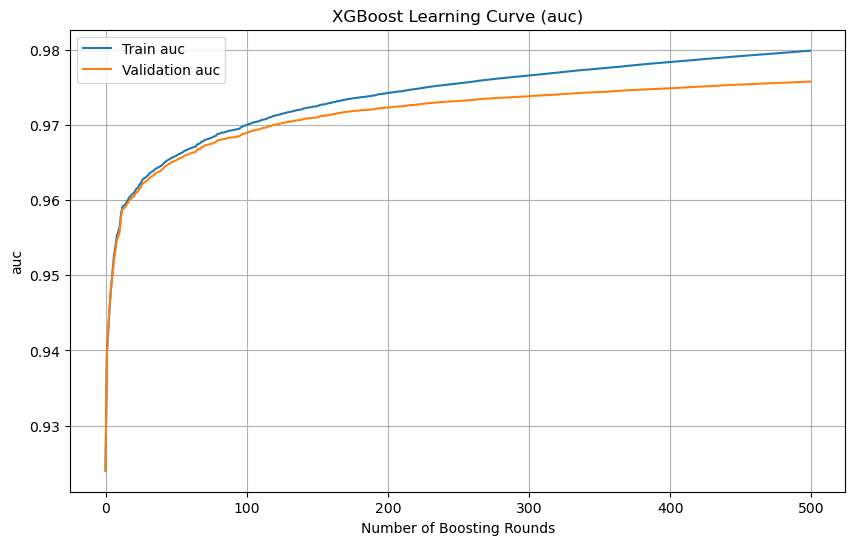

In [31]:
### plot of AUC verse boosting rounds
evals_result = xgb_only.evals_result()

x_axis = range(0, len(evals_result['validation_0']['auc']))

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['validation_0']['auc'], label='Train auc')
plt.plot(x_axis, evals_result['validation_1']['auc'], label='Validation auc')
plt.title('XGBoost Learning Curve (auc)')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('auc')
plt.legend()
plt.grid(True)
plt.show()  

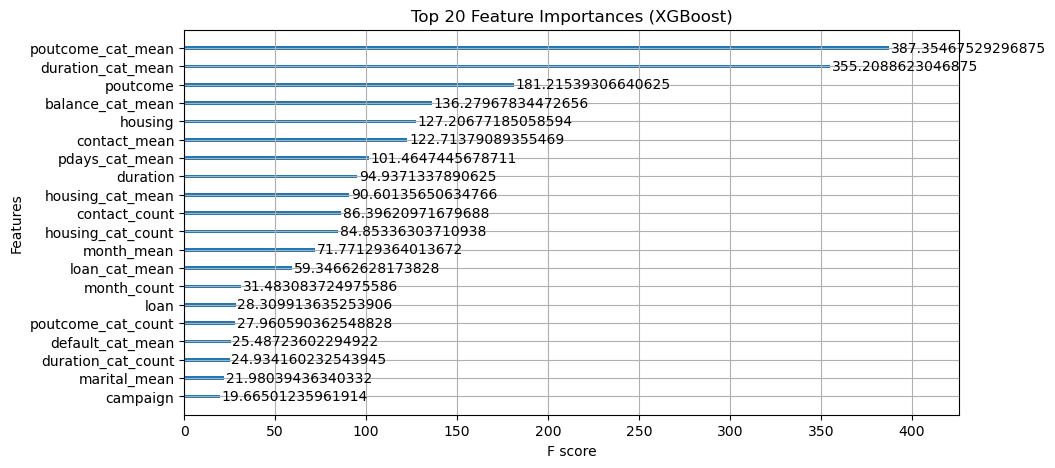

In [32]:
#### feature importance plot
fig, ax = plt.subplots(figsize=(10, 5))
xgb.plot_importance(xgb_only, max_num_features=20, importance_type='gain',ax=ax)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

#### feature importance

In [ ]:
feature_importance = xgb_only.get_booster().get_score(importance_type='gain')
to_10_imp_feautures = [x for x,y in sorted(feature_importance.items(), key=lambda item:item[1], reverse=True)[:10]]
print('Top 10 importance features: ', to_10_imp_feautures)


['poutcome_cat_mean',
 'duration_cat_mean',
 'poutcome',
 'balance_cat_mean',
 'housing',
 'contact_mean',
 'pdays_cat_mean',
 'duration',
 'housing_cat_mean',
 'contact_count']

In [ ]:
### top 10 features, train/remaining/test distribution comparison
for col in to_10_imp_feautures:
    print(col)

    fig, axs = plt.subplots(1,3, figsize=(12,6))

    sns.boxplot(y=train[col], x= Y_train, label='train',ax=axs[0])

    sns.boxplot(y=remaining[col], x=Y_remaining,  label='remain', ax=axs[1])

    sns.boxplot(y=test[col], x=[0]*len(test), label='test(0)',ax=axs[2])

    axs[0].set_title(f'train {col}')
    axs[2].set_title(f'train {col}')
    axs[3].set_title(f'train {col}')


    plt.legend(bbox_to_anchor=(1.3, 1))

    plt.show()

In [66]:
missing_feature_rank = [important_feature_sorted.index(x) for x in na_cols if x in important_feature_sorted]
print(f'total missing features in importance: {len(missing_feature_rank)}')
print(f'top 50 missing total: {(np.array(missing_feature_rank)<50).sum()}')
print(f'total missing features ranking: {sorted(missing_feature_rank)}')

total missing features in importance: 155
top 50 missing total: 34
total missing features ranking: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 36, 40, 42, 43, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 60, 61, 65, 66, 68, 71, 72, 74, 75, 76, 77, 78, 80, 82, 83, 84, 86, 87, 94, 95, 97, 98, 101, 102, 103, 105, 106, 108, 109, 113, 114, 115, 117, 120, 122, 123, 124, 125, 127, 129, 131, 133, 134, 136, 137, 139, 141, 142, 143, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 175, 177, 182, 185, 186, 189, 191, 192, 193, 194, 196, 197, 198, 199, 201, 204, 206, 209, 210, 211, 213, 214, 216, 217, 218, 223, 224, 227, 228, 229, 235, 238, 239, 240, 242, 248, 249, 251, 252]


### XGB with CV

In [24]:

#### cross validation fold
from sklearn.model_selection import KFold

FOLD= 10
kf = KFold(n_splits=FOLD, shuffle=True, random_state=30)

auc_scores = {'train':[],
              'valid':[],
              'remain':[]}

submission = {}
eval_result_by_fold = {}
model_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train.values,y_train.values), start=1):
    print(f"=== Fold {fold} ===", end=': ')
    
    # Train/val split
    X, X_val = X_train.values[train_idx], X_train.values[val_idx]
    Y, y_val = y_train.values[train_idx], y_train.values[val_idx]

    # Create model (sklearn API)
    model = xgb.XGBClassifier(
            n_estimators=2000,
            learning_rate=0.1,
            max_depth=10,
            subsample=0.8,
            reg_lambda = 0.8,
            colsample_bytree = 0.7,
            eval_metric='auc',
            max_leaves = 32,
            alpha=2,
            early_stopping_rounds = 100
            # verbose=1
    )

    # Fit with evaluation set for early stopping
    model.fit(
        X, Y,
        eval_set=[(X, Y), (X_val, y_val)],
        verbose=False
    )

    model_list.append(model)

    ## eval matrix
    eval_result_by_fold[fold] = model.evals_result()
    
    # AUC calculation: train
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    auc_scores['train'].append(auc_train)

    # AUC calculation: val
    auc_val = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
    auc_scores['valid'].append(auc_val)

    # AUC calculation: val
    auc_remain = roc_auc_score(Y_remaining, model.predict_proba(remaining)[:, 1])
    auc_scores['remain'].append(auc_remain)

    print(f"AUC: train {auc_train:.4f}, valid {auc_val:.4f}, remain: {auc_remain:.4f}")

    ### test/submission
    submission[fold] = model.predict_proba(test)[:, 1]

=== Fold 1 ===: AUC: train 0.9904, valid 0.9806, remain: 0.9661
=== Fold 2 ===: AUC: train 0.9903, valid 0.9807, remain: 0.9663
=== Fold 3 ===: AUC: train 0.9903, valid 0.9805, remain: 0.9663
=== Fold 4 ===: AUC: train 0.9903, valid 0.9805, remain: 0.9662
=== Fold 5 ===: AUC: train 0.9903, valid 0.9805, remain: 0.9662
=== Fold 6 ===: AUC: train 0.9903, valid 0.9807, remain: 0.9658
=== Fold 7 ===: AUC: train 0.9903, valid 0.9806, remain: 0.9662
=== Fold 8 ===: AUC: train 0.9903, valid 0.9807, remain: 0.9664
=== Fold 9 ===: AUC: train 0.9903, valid 0.9806, remain: 0.9660
=== Fold 10 ===: AUC: train 0.9903, valid 0.9805, remain: 0.9659


In [ ]:
# ### paralle model process
# import multiprocessing

# #### cross validation fold
# from sklearn.model_selection import KFold

# FOLD= 10
# kf = KFold(n_splits=FOLD, shuffle=True, random_state=42)


# def model_para(input_data):
    
#     fold, (train_idx, val_idx) = input_data
#     output = {}
#     fold_result = {
#         'train':[],
#         'valid':[],
#         'test':[],
#         'fold_val':[]
#     }
#     print(f'start to process fold: {fold}')
#     # Train/val split
#     X, X_val = X_train.values[train_idx], X_train.values[val_idx]
#     Y, y_val = y_train.values[train_idx], y_train.values[val_idx]
    
#         # Create model (sklearn API)
#     model = xgb.XGBClassifier(
#             n_estimators=500,
#             learning_rate=0.1,
#             max_depth=10,
#             subsample=0.8,
#             reg_lambda = 0.8,
#             colsample_bytree = 0.7,
#             eval_metric='auc',
#             max_leaves = 32,
#             alpha=2,
#             early_stopping_rounds = 50
#             # verbose=1
#     )

#     # Fit with evaluation set for early stopping
#     model.fit(
#         X, Y,
#         eval_set=[(X, Y), (X_val, y_val)],
#         verbose=False
#     )

#     ## eval matrix
#     fold_result['fold_val'] = model.evals_result()
    
#     # AUC calculation: train
#     auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
#     fold_result['train'].append(auc_train)

#     # AUC calculation: val
#     auc_val = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
#     fold_result['valid'].append(auc_val)

#     print(f"fold {fold} AUC: train {auc_train:.4f}, valid {auc_val:.4f}")

#     ### test/submission
#     fold_result['test'] = model.predict_proba(test)[:, 1]

#     output[fold] = fold_result
    
#     return output

# # %%timeit
# pool = multiprocessing.Pool(processes=os.cpu_count())
# result_map = pool.map(model_para, enumerate(kf.split(X_train.values,y_train.values), start=1))
# result_map

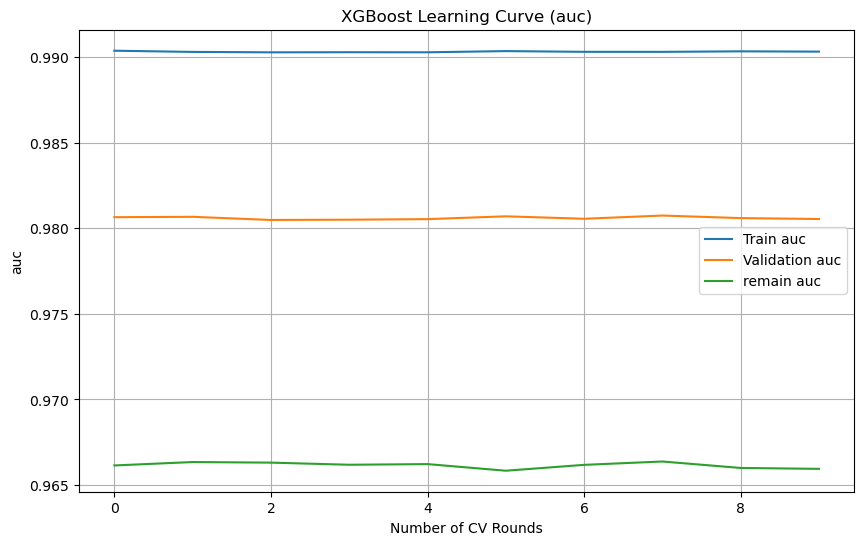

In [28]:

x_axis = range(0,len(auc_scores['train']))

valid_mean = [np.mean(auc_scores['valid'])]*len(x_axis)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, auc_scores['train'], label='Train auc')
plt.plot(x_axis, auc_scores['valid'], label='Validation auc')
plt.plot(x_axis, auc_scores['remain'], label='remain auc')
# plt.plot(x_axis, valid_mean, label='eval mean:{:.4f}'.format(np.mean(auc_scores['valid'])))
plt.title('XGBoost Learning Curve (auc)')
plt.xlabel('Number of CV Rounds')
plt.ylabel('auc')
plt.legend()
plt.grid(True)
plt.show()  

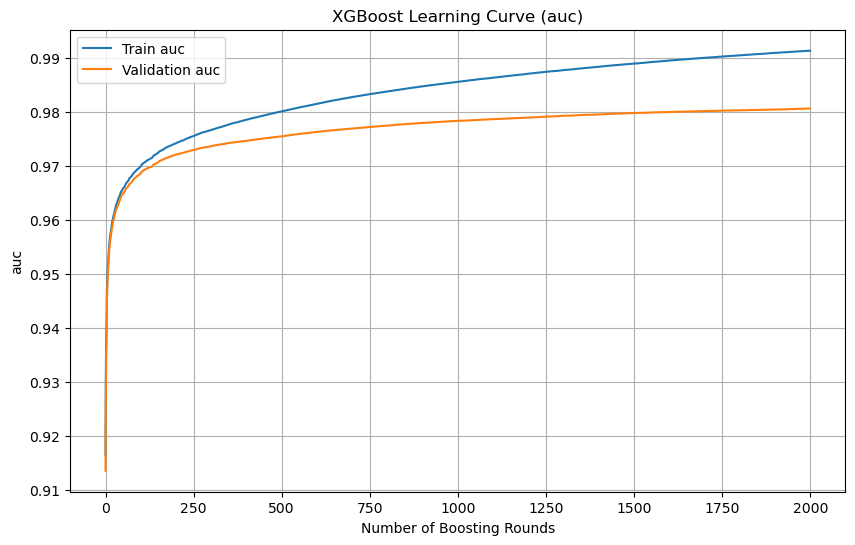

In [29]:
import random

evals_result = eval_result_by_fold[random.randint(1,FOLD)]

x_axis = range(0, len(evals_result['validation_0']['auc']))

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['validation_0']['auc'], label='Train auc')
plt.plot(x_axis, evals_result['validation_1']['auc'], label='Validation auc')
plt.title('XGBoost Learning Curve (auc)')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('auc')
plt.legend()
plt.grid(True)
plt.show() 

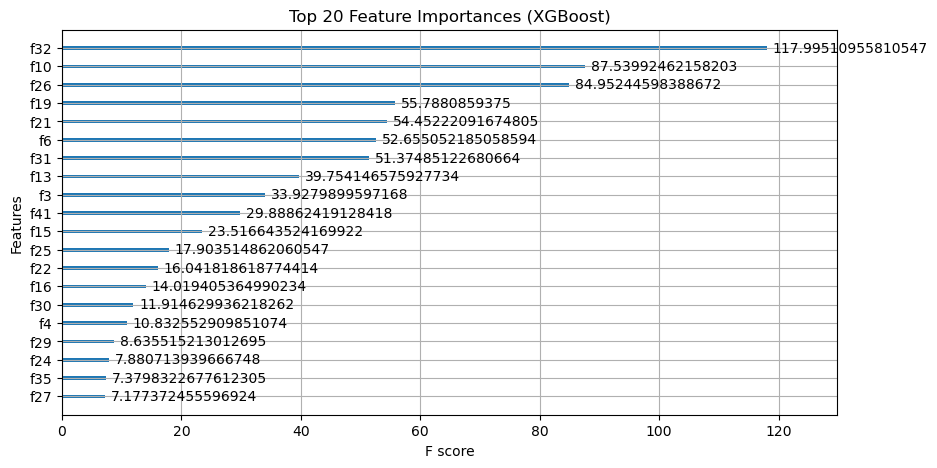

In [27]:
#### feature importance plot
fig, ax = plt.subplots(figsize=(10, 5))
xgb.plot_importance(model_list[5], max_num_features=20, importance_type='gain',ax=ax)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

In [34]:
feature_importance = model_list[5].get_booster().get_score(importance_type='gain')

feature_importance_cols = {}
columns = X_train.columns.tolist()
i=0
for i in range(len(feature_importance)):
    col = columns[i]
    feature_importance_cols[col] = feature_importance['f'+str(i)]


[x for x,y in sorted(feature_importance_cols.items(), key=lambda item:item[1], reverse=True)[:10]]

KeyError: 'f1'

In [30]:
final_pred = pd.DataFrame(submission).mean(axis=1)
predict_df['y'] = final_pred
predict_df

,id,y
0,750000,0.000029
1,750001,0.105204
2,750002,0.000180
3,750003,0.000012
4,750004,0.000015
...,...,...
249995,999995,0.000174
249996,999996,0.050875
249997,999997,0.759349
249998,999998,0.000070


In [31]:
predict_df.to_csv('submission_17_xgb_np_2000.csv',header=True, index=False)

In [ ]:
# !kaggle competitions submit -c playground-series-s5e8 -f './submission_7_xgb_with_old.csv'

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
os.getcwd()

'/kaggle/working'

### XGB only